In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("transformed_output_with_scores.csv")

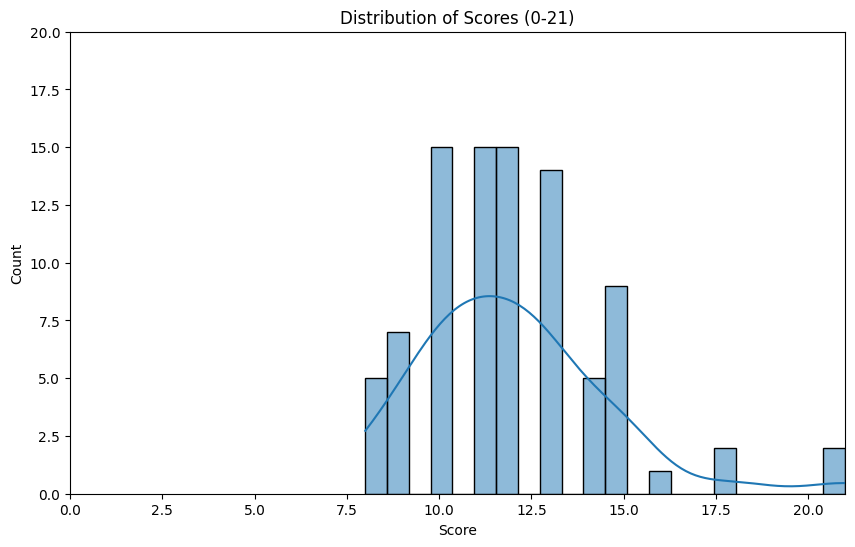

In [2]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='score', bins=22, kde=True)  # bins=22 to cover 0-21 integer range
plt.xlim(0, 21)
plt.ylim(0, 20)
plt.title('Distribution of Scores (0-21)')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

In [3]:
df_human_labels = pd.read_csv("human_labels.csv", delimiter=";")
# List all columns that are digits as strings
num_cols = [col for col in df_human_labels.columns if col.isdigit()]

# Sum those columns (they are strings)
df_human_labels['score'] = df_human_labels[num_cols].astype(float).sum(axis=1)

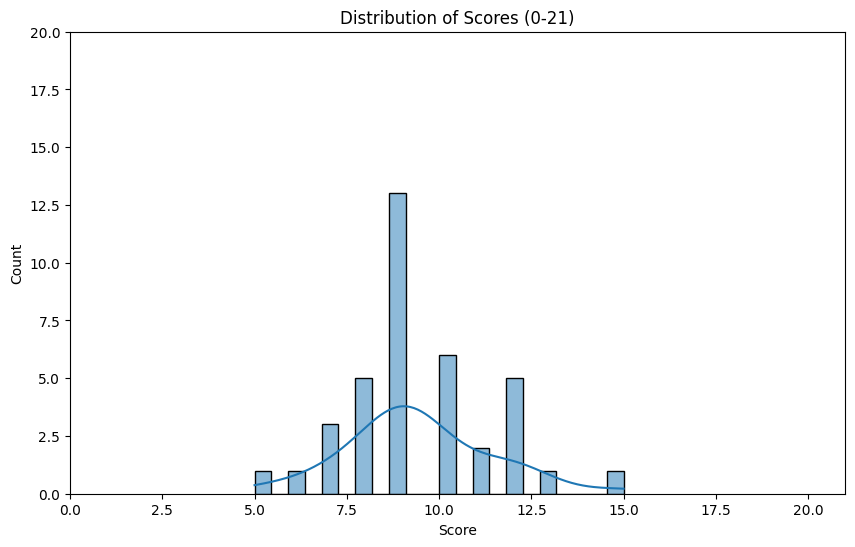

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_human_labels, x='score', bins=22, kde=True)  # bins=22 to cover 0-21 integer range
plt.xlim(0, 21)
plt.ylim(0, 20)
plt.title('Distribution of Scores (0-21)')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

In [5]:
df_human = pd.read_excel("./human_labels.xlsx")[2:].reset_index(drop=True)
df_human.dropna(subset="paper_id", inplace=True)
df_human.reset_index(drop=True, inplace=True)
df_human = df_human[["paper_id", "Score"]]

In [6]:
df = df[["paper_id", "score"]]
df1_renamed = df.rename(columns={'score': 'llm_score'})
df2_renamed = df_human.rename(columns={'Score': 'human_score'})
combined_df = pd.merge(df1_renamed, df2_renamed, on='paper_id', how='inner')

In [7]:
# Rank scores: lower score = lower rank (1 = lowest score)
combined_df['human_rank'] = combined_df['human_score'].rank(method='dense')
combined_df['llm_rank'] = combined_df['llm_score'].rank(method='dense')

combined_df['rank_diff_raw'] = combined_df['llm_rank'] - combined_df['human_rank']

# Step 3: Tolerant difference
combined_df['rank_diff_tolerant'] = combined_df['rank_diff_raw'].apply(
    lambda x: 0 if abs(x) <= 1 else x
)

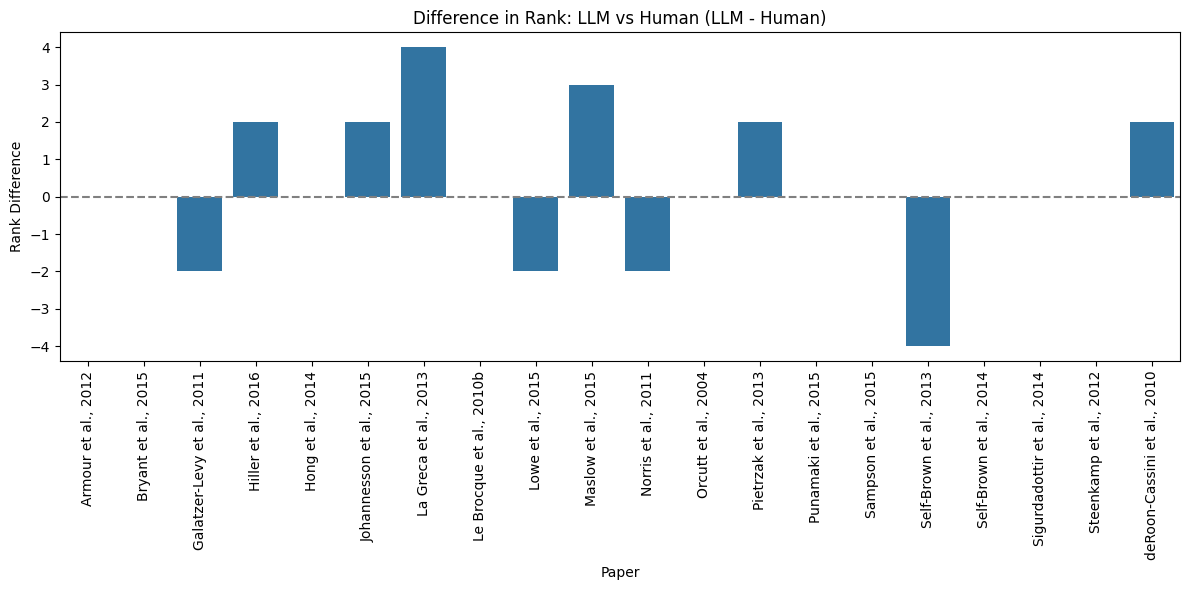

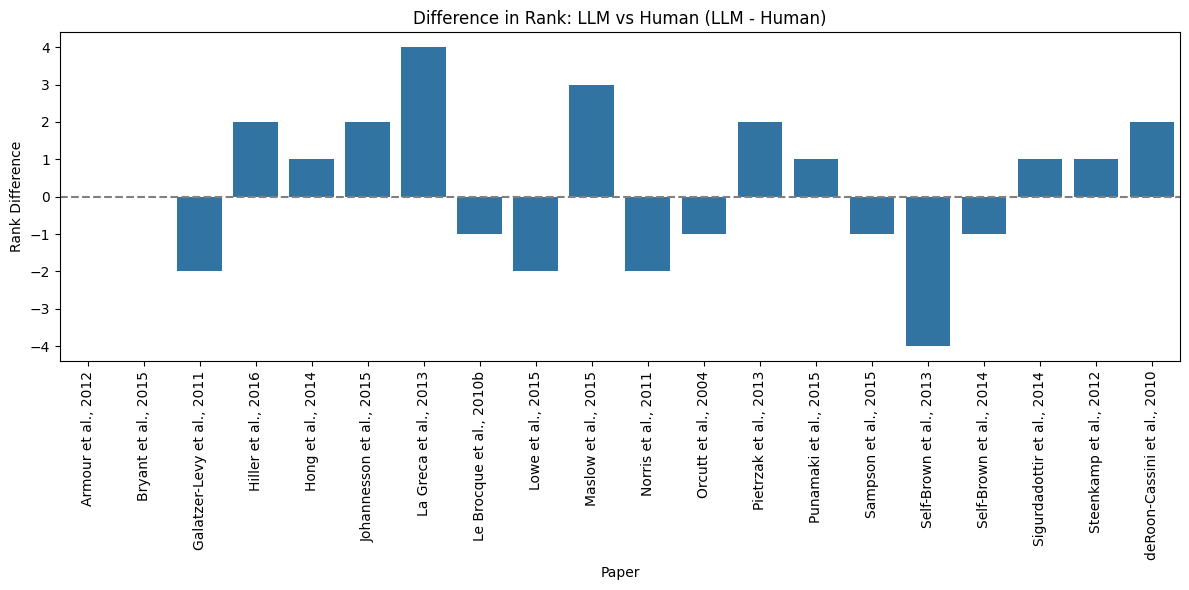

In [8]:
# Sort by human rank to make visualization intuitive
df_sorted = combined_df.sort_values('paper_id')

plt.figure(figsize=(12, 6))
sns.barplot(x='paper_id', y='rank_diff_tolerant', data=df_sorted)
plt.xticks(rotation=90)
plt.title('Difference in Rank: LLM vs Human (LLM - Human)')
plt.xlabel('Paper')
plt.ylabel('Rank Difference')
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.tight_layout()
plt.show()

# Sort by human rank to make visualization intuitive
df_sorted = combined_df.sort_values('paper_id')

plt.figure(figsize=(12, 6))
sns.barplot(x='paper_id', y='rank_diff_raw', data=df_sorted)
plt.xticks(rotation=90)
plt.title('Difference in Rank: LLM vs Human (LLM - Human)')
plt.xlabel('Paper')
plt.ylabel('Rank Difference')
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.tight_layout()
plt.show()

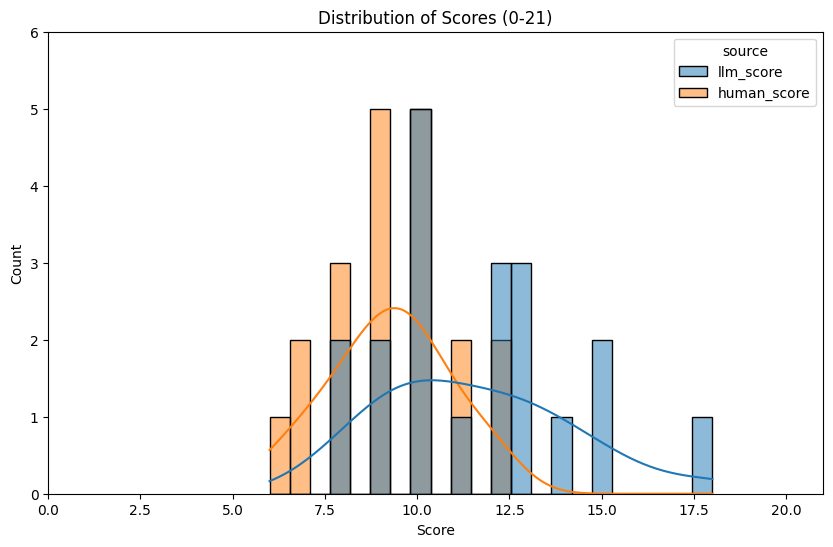

In [9]:
df_melted = combined_df.melt(
    id_vars='paper_id',
    value_vars=['llm_score', 'human_score'],
    var_name='source',
    value_name='score'
)

plt.figure(figsize=(10, 6))
sns.histplot(data=df_melted, x='score', hue='source', bins=22, kde=True)  # bins=22 to cover 0-21 integer range
plt.xlim(0, 21)
plt.ylim(0, 6)
plt.title('Distribution of Scores (0-21)')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

In [10]:
from scipy.stats import spearmanr, kendalltau

rho, p_value = spearmanr(combined_df['human_score'], combined_df['llm_score'])
print(f"Spearman correlation (ρ): {rho:.3f}, p-value: {p_value:.4f}")

tau, p_value = kendalltau(combined_df['human_score'], combined_df['llm_score'])
print(f"Kendall’s tau (τ): {tau:.3f}, p-value: {p_value:.4f}")

Spearman correlation (ρ): 0.521, p-value: 0.0184
Kendall’s tau (τ): 0.382, p-value: 0.0315
